In [1]:
from brian2 import *
from brian2tools import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

figures_path = 'figures/'
#setting path to save network state
########Set this to your personal disk/scratch partition
save_path = '/disk/scratch/prubisch/brian_data/'

(5000, 10, 10)


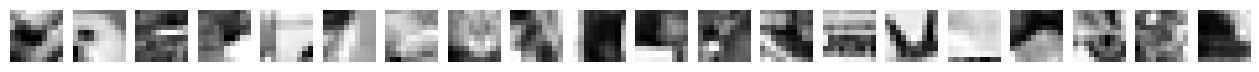

In [2]:
images = np.load('cifar_patches_10x10_zca.npz')['images']
images = images - images.mean()
# plot 10 images
figure(figsize=(16, 10))
for i in range(20):
    subplot(1, 20, i+1)
    imshow(images[i], cmap=plt.cm.gray)#, vmin=-1, vmax=1)
    axis('off')


images[0].min(), images[0].max()

print(images.shape)


In [3]:
start_scope()

seed(42)

# VDP parameters
##########################################

Apre = 0.03
k_minus = 1 / mV
k_plus = .7 / mV
test_c_ca = 3.0
tau_glutamate = 10 * ms
tau_NMDA_fall = 10 * ms
tau_NMDA_rise = 1 * ms
theta_NMDA = -63 * mV
k_LTP = k_plus 
tau_VDCC_fall = 30 * ms
tau_VDCC_rise = 12 * ms
theta_VDCC = -66 * mV
k_LTD = k_minus
tau_Ca = 1 * ms
NMDA_amp = (tau_NMDA_rise/tau_NMDA_fall)**(tau_NMDA_fall/(tau_NMDA_rise - tau_NMDA_fall))
VDCC_amp = (tau_VDCC_rise/tau_VDCC_fall)**(tau_VDCC_fall/(tau_VDCC_rise - tau_VDCC_fall))
tau_w = 1 * ms
LTP_amp = 1
LTD_amp = .95

# VDP equations
##########################################

syn_eq = '''
    dglutamate/dt = - glutamate/tau_glutamate : 1 (clock-driven)
    sig_LTP = 1/(1+exp(k_LTP*(-(v - theta_NMDA)+0*mV))) : 1 (constant over dt)
    dv_NMDA_rise/dt = (-v_NMDA_rise + clip(clip(sig_LTP - v_NMDA,0,100) - v_NMDA_rise,0,100))/tau_NMDA_rise : 1 (clock-driven)             
    dv_NMDA/dt = (NMDA_amp * v_NMDA_rise - v_NMDA)/tau_NMDA_fall : 1 (clock-driven)
    sig_LTD = 1/(1+exp(k_LTD*(-(v - theta_VDCC)+0*mV))) : 1 (constant over dt)
    dVDCC_rise/dt = (-VDCC_rise + clip(clip(sig_LTD - VDCC,0,100) -VDCC_rise, 0, 100))/tau_VDCC_rise : 1 (clock-driven) 
    dVDCC/dt = (VDCC_amp * VDCC_rise - VDCC) * 1/tau_VDCC_fall : 1 (clock-driven)
    Ca = VDCC**3 + v_NMDA**3 * int(glutamate>0) : 1 (constant over dt)
    dw/dt = clip(Ca  * glutamate * (v_NMDA * LTP_amp - VDCC * LTD_amp) * glutamate/tau_w*dt,(0.01-w),(1-w))/dt : 1 (clock-driven)
'''
#c_ca = 1.8-1.9

# Neurons with Ornstien-Uhlenbeck noise
##########################################

vrest = -70 * mV
tau_syn_e = 2 * ms 
tau_syn_i = 2 * ms


# reversal potentials
E_exc = 0 * mV 
E_inh = -80 * mV

neuron_eqs = '''
    dv/dt = (vrest-v)/tau - I_syn_e * (v-E_exc)/tau - I_syn_i * (v-E_inh)/tau + n_sigma*xi*tau**-0.5 : volt (unless refractory)
    dI_syn_e/dt = -I_syn_e/tau_syn_e : 1
    dI_syn_i/dt = -I_syn_i/tau_syn_i : 1
    dvt/dt = (-60*mV-vt)/(30*ms) : volt
    n_sigma : volt
    tau : second
'''

reset = '''
v = -75*mV
vt += 0.0*mV
'''

# excitatory neurons
N_exc = 200
N_inh = 50
N_exc_in = N_exc

GE = NeuronGroup(N_exc, neuron_eqs, reset=reset, threshold='v>vt',
                refractory=0*ms, method='euler')
GE.n_sigma = 3 * mV
GE.v = vrest
GE.vt = -69*mV
GE.tau = 5*ms
GE.ref_amp = 0

# inhibitory neurons
GI = NeuronGroup(N_inh, neuron_eqs, reset=reset, threshold='v>vt',
                refractory=0*ms, method='euler')
GI.n_sigma = 0 * mV
GI.v = vrest
GI.vt = -69*mV
GI.tau = 2*ms
GI.ref_amp = 0

# Inputs
##########################################

N_stim = 10

stim_eqs = '''
            dI/dt = (-I + I_in - 2*I2) /(10*ms) : 1
            dI2/dt = (-I2 + I) /(40*ms) : 1
            dv/dt = (-v + I)/(5*ms)  : 1
            dtheta/dt = (0.2 - theta)/(10*ms) + n_sigma*xi*(10*ms)**-0.5 : 1
            I_in : 1  # one stimulus per neuron
            n_sigma : 1 
            '''

IG1 = NeuronGroup(N_stim*N_stim, stim_eqs,
                        threshold = 'v > theta',
                        refractory = 5*ms,
                        reset = 'v=0')

IG2 = NeuronGroup(N_stim*N_stim, stim_eqs,
                        threshold = 'v > theta',
                        refractory = 5*ms,
                        reset = 'v=0')

n_stim = 1000
length_stim = 50
presentation = np.arange(n_stim)

@network_operation(dt = n_stim * length_stim *ms)
def presentation_order(t): 
    presentation = np.random.permutation(n_stim)

@network_operation(dt=length_stim*ms)
def stripes_bars(t):
    pattern = images[presentation[int(t/(length_stim*ms))%n_stim]]
    IG1.I_in = pattern.flatten()*1
    IG1.I = 0
    IG1.I2 = 0
    IG2.I_in = -pattern.flatten()*1
    IG2.I = 0
    IG2.I2 = 0

IG1.n_sigma = 0
IG2.n_sigma = 0

# Synapses
##########################################

# conductances
sf = .1
IG_g = 10/np.sqrt(2*N_stim)*sf
IG_I_g = 10/np.sqrt(N_stim*N_stim)*sf*0
EE_g = 10/np.sqrt(4)*sf*0.1
IE_g = 10/N_exc*sf
EI_g = 10/np.sqrt(N_inh)*sf*3
II_g = 10/np.sqrt(4)*sf


S_EE = Synapses(GE, GE, syn_eq,
             on_pre='''
             I_syn_e += w * EE_g
             glutamate += Apre
             ''', 
             method='euler')
S_EE.connect(j='(i + k) % N_exc for k in range(-1, 1, 2)')
S_EE.connect(j='(i - k) % N_exc for k in range(-1, 1, 2)')
S_EE.connect(j='(i + k) % N_exc for k in range(-2, 2, 4)')
S_EE.connect(j='(i - k) % N_exc for k in range(-2, 2, 4)')

S_IE = Synapses(GE, GI, syn_eq,
             on_pre='''
             I_syn_e += w * IE_g
             glutamate += Apre
             ''', method='euler')
S_IE.connect(p=1)

S_II = Synapses(GI, GI, syn_eq,
             on_pre='''
             I_syn_i += w * II_g
             glutamate += Apre
             ''', method='euler')
S_II.connect(j='(i + k) % N_inh for k in range(-1, 1, 2)')
S_II.connect(j='(i - k) % N_inh for k in range(-1, 1, 2)')
S_II.connect(j='(i + k) % N_inh for k in range(-2, 2, 4)')
S_II.connect(j='(i - k) % N_inh for k in range(-2, 2, 4)')


S_EI = Synapses(GI, GE, syn_eq,
             on_pre='''
             I_syn_i += w * EI_g
             glutamate += Apre
             ''', method='euler')
S_EI.connect(p=1)

S_IG1 = Synapses(IG1, GE[:N_exc_in], syn_eq,
             on_pre='''
             I_syn_e += w * IG_g
             glutamate += Apre
             ''', method='euler')
S_IG1.connect(p=1)

S_IG2 = Synapses(IG2, GE[:N_exc_in], syn_eq,
             on_pre='''
             I_syn_e += w * IG_g
             glutamate += Apre
             ''', method='euler')
S_IG2.connect(p=1)

S_IG1.w = '.7*rand()+.2'
S_IG2.w = '.7*rand()+.2'
S_EE.w = '.7*rand()+.2'
S_IE.w = '.7*rand()+.2'
S_EI.w = '.7*rand()+.2'
S_II.w = '.7*rand()+.2'

S_IG1.w = 'rand()'
S_IG2.w = 'rand()'
S_EE.w = '.7*rand()'
S_IE.w = '.7*rand()'
S_EI.w = '.7*rand()'
S_II.w = '.7*rand()'

# Monitors
##########################################

rate_monitor_E = PopulationRateMonitor(GE)
rate_monitor_I = PopulationRateMonitor(GI)

spike_monitor_E = SpikeMonitor(GE)
spike_monitor_I = SpikeMonitor(GI)
spike_monitor_IG1 = SpikeMonitor(IG1)
spike_monitor_IG2 = SpikeMonitor(IG2)

    
recorded_cells = [5,13,24,26]

M_IG1 = StateMonitor(S_IG1, ['w'], record=S_IG1[:,recorded_cells], dt=10 * second)
M_IG2 = StateMonitor(S_IG2, ['w'], record=S_IG2[:,recorded_cells], dt=10 * second)






INFO:root:creating /tmp/brian_flag_test_8c5_h9mw/tmp
INFO:root:creating /tmp/brian_flag_test_8c5_h9mw/tmp/brian_flag_test_8c5_h9mw
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -c /tmp/brian_flag_test_8c5_h9mw/flag_test.cpp -o /tmp/brian_flag_test_8c5_h9mw/tmp/brian_flag_test_8c5_h9mw/flag_test.o -w
INFO:root:creating /tmp/brian_flag_test_p4mym10k/tmp
INFO:root:creating /tmp/brian_flag_test_p4mym10k/tmp/brian_flag_test_p4mym10k
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -c /tmp/brian_flag_test_p4mym10k/flag_test.cpp -o /tmp/brian_flag_test_p4mym10k/tmp/brian_flag_test_p4mym10k/flag_test.o -O3
INFO:root:creating /tmp/brian_flag_test_ghzo8xwi/tmp
INFO:root:creating /tmp/brian_flag_test_ghzo8xwi/tmp/brian_flag_test_ghzo8xwi
INFO

In [4]:
# warm up, only run for intital simulation, not when reloading last network state!

# plot voltage traces

M_E_v = StateMonitor(GE, ['v'], record=range(5), dt=.1 * ms)
M_I_v = StateMonitor(GI, ['v'], record=range(5), dt=.1 * ms)
run(500*ms)
figure(figsize=(12,4))
subplot(211)
plot(M_E_v.t/ms, M_E_v.v[0]/mV, 'r', label='E')
# plot(M_E_v.t/ms, M_E_v.v[1]/mV, 'r')
subplot(212)
plot(M_I_v.t/ms, M_I_v.v[0]/mV, 'b', label='I')
# plot(M_I_v.t/ms, M_I_v.v[1]/mV, 'b')
del M_E_v
del M_I_v

In [9]:
run(1000 * second, report = 'text') 

store(filename = save_path+'last_state_receptive_fields_network_proper_randomised')

W_inp1 = np.full([N_stim**2, N_exc], np.nan)
W_inp1[S_IG1.i[:], S_IG1.j[:]] = S_IG1.w[:]

W_inp2 = np.full([N_stim**2, N_exc], np.nan)
W_inp2[S_IG2.i[:], S_IG2.j[:]] = S_IG2.w[:]

np.save('simulation_results/receptive_fields_W_vdp.npy', [W_inp1,W_inp2])

INFO:root:building '_cython_magic_5781c8db067fc4b58529e70d052d47e5' extension
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/disk/scratch/prubisch/miniconda/envs/brian_env/include -I/afs/inf.ed.ac.uk/user/s15/s1576881/.local/lib/python3.8/site-packages/numpy/core/include -I/afs/inf.ed.ac.uk/user/s15/s1576881/.local/lib/python3.8/site-packages/brian2/synapses -I/disk/scratch/prubisch/miniconda/envs/brian_env/include/python3.8 -c /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_5781c8db067fc4b58529e70d052d47e5.cpp -o /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_5781c8db067fc4b58529e70d052d47e5.o -w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11
INFO:root:g++ -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_c

INFO:root:building '_cython_magic_a61907e04204c6de97d27927e54751fb' extension
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/disk/scratch/prubisch/miniconda/envs/brian_env/include -I/afs/inf.ed.ac.uk/user/s15/s1576881/.local/lib/python3.8/site-packages/numpy/core/include -I/afs/inf.ed.ac.uk/user/s15/s1576881/.local/lib/python3.8/site-packages/brian2/synapses -I/disk/scratch/prubisch/miniconda/envs/brian_env/include/python3.8 -c /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_a61907e04204c6de97d27927e54751fb.cpp -o /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_a61907e04204c6de97d27927e54751fb.o -w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11
INFO:root:g++ -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_c

INFO:root:building '_cython_magic_96c8bc20c4abb3e6c1706d69398f0ba9' extension
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/disk/scratch/prubisch/miniconda/envs/brian_env/include -I/afs/inf.ed.ac.uk/user/s15/s1576881/.local/lib/python3.8/site-packages/numpy/core/include -I/afs/inf.ed.ac.uk/user/s15/s1576881/.local/lib/python3.8/site-packages/brian2/synapses -I/disk/scratch/prubisch/miniconda/envs/brian_env/include/python3.8 -c /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_96c8bc20c4abb3e6c1706d69398f0ba9.cpp -o /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_96c8bc20c4abb3e6c1706d69398f0ba9.o -w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11
INFO:root:g++ -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_c

INFO:root:building '_cython_magic_a6579fa8961bafb506431415b1a515e0' extension
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/disk/scratch/prubisch/miniconda/envs/brian_env/include -I/afs/inf.ed.ac.uk/user/s15/s1576881/.local/lib/python3.8/site-packages/numpy/core/include -I/afs/inf.ed.ac.uk/user/s15/s1576881/.local/lib/python3.8/site-packages/brian2/synapses -I/disk/scratch/prubisch/miniconda/envs/brian_env/include/python3.8 -c /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_a6579fa8961bafb506431415b1a515e0.cpp -o /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_a6579fa8961bafb506431415b1a515e0.o -w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11
INFO:root:g++ -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_c

INFO:root:building '_cython_magic_4bb414de54f4fd7b1fa442ff272d4315' extension
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/disk/scratch/prubisch/miniconda/envs/brian_env/include -I/afs/inf.ed.ac.uk/user/s15/s1576881/.local/lib/python3.8/site-packages/numpy/core/include -I/afs/inf.ed.ac.uk/user/s15/s1576881/.local/lib/python3.8/site-packages/brian2/synapses -I/disk/scratch/prubisch/miniconda/envs/brian_env/include/python3.8 -c /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_4bb414de54f4fd7b1fa442ff272d4315.cpp -o /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_4bb414de54f4fd7b1fa442ff272d4315.o -w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11
INFO:root:g++ -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_c

Starting simulation at t=0.5005 ks for a duration of 0.5 ks
143.6 ms (0%) simulated in 10s, estimated 9h 40m 23s remaining.
297.4 ms (0%) simulated in 20s, estimated 9h 20m 19s remaining.
0.4508 s (0%) simulated in 30s, estimated 9h 14m 20s remaining.
0.604 s (0%) simulated in 40s, estimated 9h 11m 26s remaining.
0.7571 s (0%) simulated in 50s, estimated 9h 9m 45s remaining.
0.9103 s (0%) simulated in 1m 0s, estimated 9h 8m 30s remaining.
1.0631 s (0%) simulated in 1m 10s, estimated 9h 7m 48s remaining.
1.2167 s (0%) simulated in 1m 20s, estimated 9h 6m 50s remaining.
1.371 s (0%) simulated in 1m 30s, estimated 9h 5m 46s remaining.
1.5245 s (0%) simulated in 1m 40s, estimated 9h 5m 10s remaining.
1.6776 s (0%) simulated in 1m 50s, estimated 9h 4m 48s remaining.
1.8309 s (0%) simulated in 2m 0s, estimated 9h 4m 24s remaining.
1.9839 s (0%) simulated in 2m 10s, estimated 9h 4m 7s remaining.
2.1372 s (0%) simulated in 2m 20s, estimated 9h 3m 46s remaining.
2.291 s (0%) simulated in 2m 30s

18.8186 s (3%) simulated in 20m 30s, estimated 8h 44m 21s remaining.
18.9711 s (3%) simulated in 20m 40s, estimated 8h 44m 11s remaining.
19.1237 s (3%) simulated in 20m 50s, estimated 8h 44m 2s remaining.
19.2767 s (3%) simulated in 21m 0s, estimated 8h 43m 52s remaining.
19.4299 s (3%) simulated in 21m 10s, estimated 8h 43m 42s remaining.
19.5825 s (3%) simulated in 21m 20s, estimated 8h 43m 32s remaining.
19.736 s (3%) simulated in 21m 30s, estimated 8h 43m 22s remaining.
19.8889 s (3%) simulated in 21m 40s, estimated 8h 43m 12s remaining.
20.043 s (4%) simulated in 21m 50s, estimated 8h 43m 0s remaining.
20.1963 s (4%) simulated in 22m 0s, estimated 8h 42m 49s remaining.
20.3501 s (4%) simulated in 22m 10s, estimated 8h 42m 38s remaining.
20.5036 s (4%) simulated in 22m 20s, estimated 8h 42m 27s remaining.
20.6546 s (4%) simulated in 22m 30s, estimated 8h 42m 21s remaining.
20.8078 s (4%) simulated in 22m 40s, estimated 8h 42m 10s remaining.
20.9603 s (4%) simulated in 22m 50s, est

37.1839 s (7%) simulated in 40m 30s, estimated 8h 24m 15s remaining.
37.3369 s (7%) simulated in 40m 40s, estimated 8h 24m 5s remaining.
37.4895 s (7%) simulated in 40m 50s, estimated 8h 23m 56s remaining.
37.6427 s (7%) simulated in 41m 0s, estimated 8h 23m 45s remaining.
37.7956 s (7%) simulated in 41m 10s, estimated 8h 23m 35s remaining.
37.9482 s (7%) simulated in 41m 20s, estimated 8h 23m 26s remaining.
38.1006 s (7%) simulated in 41m 30s, estimated 8h 23m 16s remaining.
38.254 s (7%) simulated in 41m 40s, estimated 8h 23m 6s remaining.
38.4066 s (7%) simulated in 41m 50s, estimated 8h 22m 56s remaining.
38.5588 s (7%) simulated in 42m 0s, estimated 8h 22m 47s remaining.
38.7112 s (7%) simulated in 42m 10s, estimated 8h 22m 38s remaining.
38.8634 s (7%) simulated in 42m 20s, estimated 8h 22m 28s remaining.
39.0145 s (7%) simulated in 42m 30s, estimated 8h 22m 20s remaining.
39.1659 s (7%) simulated in 42m 40s, estimated 8h 22m 11s remaining.
39.3176 s (7%) simulated in 42m 50s, es

58.8977 s (11%) simulated in 1h 2m 1s, estimated 7h 44m 29s remaining.
59.0535 s (11%) simulated in 1h 2m 11s, estimated 7h 44m 20s remaining.
59.2093 s (11%) simulated in 1h 2m 21s, estimated 7h 44m 12s remaining.
59.3636 s (11%) simulated in 1h 2m 31s, estimated 7h 44m 4s remaining.
59.5177 s (11%) simulated in 1h 2m 41s, estimated 7h 43m 56s remaining.
59.6737 s (11%) simulated in 1h 2m 51s, estimated 7h 43m 47s remaining.
59.8291 s (11%) simulated in 1h 3m 1s, estimated 7h 43m 39s remaining.
59.9848 s (11%) simulated in 1h 3m 11s, estimated 7h 43m 30s remaining.
60.1401 s (12%) simulated in 1h 3m 21s, estimated 7h 43m 22s remaining.
60.2945 s (12%) simulated in 1h 3m 31s, estimated 7h 43m 14s remaining.
60.4502 s (12%) simulated in 1h 3m 41s, estimated 7h 43m 5s remaining.
60.6044 s (12%) simulated in 1h 3m 51s, estimated 7h 42m 57s remaining.
60.7582 s (12%) simulated in 1h 4m 1s, estimated 7h 42m 49s remaining.
60.9134 s (12%) simulated in 1h 4m 11s, estimated 7h 42m 41s remainin

76.4467 s (15%) simulated in 1h 21m 1s, estimated 7h 28m 55s remaining.
76.6002 s (15%) simulated in 1h 21m 11s, estimated 7h 28m 47s remaining.
76.7538 s (15%) simulated in 1h 21m 21s, estimated 7h 28m 39s remaining.
76.907 s (15%) simulated in 1h 21m 31s, estimated 7h 28m 30s remaining.
77.0597 s (15%) simulated in 1h 21m 41s, estimated 7h 28m 22s remaining.
77.2121 s (15%) simulated in 1h 21m 51s, estimated 7h 28m 14s remaining.
77.3655 s (15%) simulated in 1h 22m 1s, estimated 7h 28m 6s remaining.
77.5191 s (15%) simulated in 1h 22m 11s, estimated 7h 27m 57s remaining.
77.6717 s (15%) simulated in 1h 22m 21s, estimated 7h 27m 49s remaining.
77.8243 s (15%) simulated in 1h 22m 31s, estimated 7h 27m 41s remaining.
77.9767 s (15%) simulated in 1h 22m 41s, estimated 7h 27m 33s remaining.
78.1294 s (15%) simulated in 1h 22m 51s, estimated 7h 27m 25s remaining.
78.2827 s (15%) simulated in 1h 23m 1s, estimated 7h 27m 16s remaining.
78.4361 s (15%) simulated in 1h 23m 11s, estimated 7h 27

93.7464 s (18%) simulated in 1h 39m 51s, estimated 7h 12m 46s remaining.
93.8991 s (18%) simulated in 1h 40m 1s, estimated 7h 12m 38s remaining.
94.0521 s (18%) simulated in 1h 40m 11s, estimated 7h 12m 29s remaining.
94.2049 s (18%) simulated in 1h 40m 21s, estimated 7h 12m 20s remaining.
94.3581 s (18%) simulated in 1h 40m 31s, estimated 7h 12m 11s remaining.
94.5111 s (18%) simulated in 1h 40m 41s, estimated 7h 12m 2s remaining.
94.664 s (18%) simulated in 1h 40m 51s, estimated 7h 11m 53s remaining.
94.8228 s (18%) simulated in 1h 41m 1s, estimated 7h 11m 43s remaining.
95.0605 s (19%) simulated in 1h 41m 11s, estimated 7h 11m 5s remaining.
95.2976 s (19%) simulated in 1h 41m 21s, estimated 7h 10m 28s remaining.
95.535 s (19%) simulated in 1h 41m 31s, estimated 7h 9m 51s remaining.
95.7734 s (19%) simulated in 1h 41m 41s, estimated 7h 9m 14s remaining.
96.0122 s (19%) simulated in 1h 41m 51s, estimated 7h 8m 37s remaining.
96.2504 s (19%) simulated in 1h 42m 1s, estimated 7h 8m 0s r

112.9584 s (22%) simulated in 1h 58m 42s, estimated 6h 46m 44s remaining.
113.1134 s (22%) simulated in 1h 58m 52s, estimated 6h 46m 35s remaining.
113.2683 s (22%) simulated in 1h 59m 2s, estimated 6h 46m 26s remaining.
113.4225 s (22%) simulated in 1h 59m 12s, estimated 6h 46m 17s remaining.
113.5776 s (22%) simulated in 1h 59m 22s, estimated 6h 46m 8s remaining.
113.7332 s (22%) simulated in 1h 59m 32s, estimated 6h 45m 59s remaining.
113.8888 s (22%) simulated in 1h 59m 42s, estimated 6h 45m 50s remaining.
114.0436 s (22%) simulated in 1h 59m 52s, estimated 6h 45m 41s remaining.
114.1989 s (22%) simulated in 2h 0m 2s, estimated 6h 45m 32s remaining.
114.3531 s (22%) simulated in 2h 0m 12s, estimated 6h 45m 23s remaining.
114.5076 s (22%) simulated in 2h 0m 22s, estimated 6h 45m 14s remaining.
114.6627 s (22%) simulated in 2h 0m 32s, estimated 6h 45m 5s remaining.
114.8181 s (22%) simulated in 2h 0m 42s, estimated 6h 44m 56s remaining.
114.9738 s (22%) simulated in 2h 0m 52s, estima

130.4681 s (26%) simulated in 2h 17m 32s, estimated 6h 29m 34s remaining.
130.6236 s (26%) simulated in 2h 17m 42s, estimated 6h 29m 25s remaining.
130.7783 s (26%) simulated in 2h 17m 52s, estimated 6h 29m 16s remaining.
130.933 s (26%) simulated in 2h 18m 2s, estimated 6h 29m 7s remaining.
131.0877 s (26%) simulated in 2h 18m 12s, estimated 6h 28m 57s remaining.
131.2426 s (26%) simulated in 2h 18m 22s, estimated 6h 28m 48s remaining.
131.3978 s (26%) simulated in 2h 18m 32s, estimated 6h 28m 39s remaining.
131.5532 s (26%) simulated in 2h 18m 42s, estimated 6h 28m 30s remaining.
131.7081 s (26%) simulated in 2h 18m 52s, estimated 6h 28m 20s remaining.
131.8633 s (26%) simulated in 2h 19m 2s, estimated 6h 28m 11s remaining.
132.0185 s (26%) simulated in 2h 19m 12s, estimated 6h 28m 2s remaining.
132.1729 s (26%) simulated in 2h 19m 22s, estimated 6h 27m 53s remaining.
132.3281 s (26%) simulated in 2h 19m 32s, estimated 6h 27m 43s remaining.
132.4836 s (26%) simulated in 2h 19m 42s, e

147.8708 s (29%) simulated in 2h 36m 13s, estimated 6h 12m 0s remaining.
148.0265 s (29%) simulated in 2h 36m 23s, estimated 6h 11m 51s remaining.
148.1818 s (29%) simulated in 2h 36m 33s, estimated 6h 11m 41s remaining.
148.3374 s (29%) simulated in 2h 36m 43s, estimated 6h 11m 32s remaining.
148.4923 s (29%) simulated in 2h 36m 53s, estimated 6h 11m 22s remaining.
148.6478 s (29%) simulated in 2h 37m 3s, estimated 6h 11m 13s remaining.
148.8038 s (29%) simulated in 2h 37m 13s, estimated 6h 11m 3s remaining.
148.9587 s (29%) simulated in 2h 37m 23s, estimated 6h 10m 54s remaining.
149.1138 s (29%) simulated in 2h 37m 33s, estimated 6h 10m 44s remaining.
149.2683 s (29%) simulated in 2h 37m 43s, estimated 6h 10m 35s remaining.
149.4232 s (29%) simulated in 2h 37m 53s, estimated 6h 10m 26s remaining.
149.5783 s (29%) simulated in 2h 38m 3s, estimated 6h 10m 16s remaining.
149.7341 s (29%) simulated in 2h 38m 13s, estimated 6h 10m 7s remaining.
149.889 s (29%) simulated in 2h 38m 23s, es

165.3666 s (33%) simulated in 2h 55m 3s, estimated 5h 54m 14s remaining.
165.5212 s (33%) simulated in 2h 55m 13s, estimated 5h 54m 5s remaining.
165.6764 s (33%) simulated in 2h 55m 23s, estimated 5h 53m 55s remaining.
165.831 s (33%) simulated in 2h 55m 33s, estimated 5h 53m 46s remaining.
165.9851 s (33%) simulated in 2h 55m 43s, estimated 5h 53m 37s remaining.
166.139 s (33%) simulated in 2h 55m 53s, estimated 5h 53m 27s remaining.
166.293 s (33%) simulated in 2h 56m 3s, estimated 5h 53m 18s remaining.
166.4476 s (33%) simulated in 2h 56m 13s, estimated 5h 53m 9s remaining.
166.604 s (33%) simulated in 2h 56m 23s, estimated 5h 52m 59s remaining.
166.7596 s (33%) simulated in 2h 56m 33s, estimated 5h 52m 49s remaining.
166.9154 s (33%) simulated in 2h 56m 43s, estimated 5h 52m 39s remaining.
167.0707 s (33%) simulated in 2h 56m 53s, estimated 5h 52m 30s remaining.
167.2267 s (33%) simulated in 2h 57m 3s, estimated 5h 52m 20s remaining.
167.3826 s (33%) simulated in 2h 57m 13s, estim

182.8988 s (36%) simulated in 3h 13m 53s, estimated 5h 36m 10s remaining.
183.0543 s (36%) simulated in 3h 14m 3s, estimated 5h 36m 0s remaining.
183.2099 s (36%) simulated in 3h 14m 13s, estimated 5h 35m 51s remaining.
183.3647 s (36%) simulated in 3h 14m 23s, estimated 5h 35m 41s remaining.
183.5193 s (36%) simulated in 3h 14m 33s, estimated 5h 35m 31s remaining.
183.6741 s (36%) simulated in 3h 14m 43s, estimated 5h 35m 22s remaining.
183.8292 s (36%) simulated in 3h 14m 53s, estimated 5h 35m 12s remaining.
183.985 s (36%) simulated in 3h 15m 3s, estimated 5h 35m 2s remaining.
184.1408 s (36%) simulated in 3h 15m 13s, estimated 5h 34m 53s remaining.
184.2964 s (36%) simulated in 3h 15m 23s, estimated 5h 34m 43s remaining.
184.4522 s (36%) simulated in 3h 15m 33s, estimated 5h 34m 33s remaining.
184.6077 s (36%) simulated in 3h 15m 43s, estimated 5h 34m 24s remaining.
184.7629 s (36%) simulated in 3h 15m 53s, estimated 5h 34m 14s remaining.
184.918 s (36%) simulated in 3h 16m 3s, est

200.2366 s (40%) simulated in 3h 32m 34s, estimated 5h 18m 13s remaining.
200.3919 s (40%) simulated in 3h 32m 44s, estimated 5h 18m 4s remaining.
200.547 s (40%) simulated in 3h 32m 54s, estimated 5h 17m 54s remaining.
200.7028 s (40%) simulated in 3h 33m 4s, estimated 5h 17m 44s remaining.
200.8576 s (40%) simulated in 3h 33m 14s, estimated 5h 17m 35s remaining.
201.012 s (40%) simulated in 3h 33m 24s, estimated 5h 17m 25s remaining.
201.167 s (40%) simulated in 3h 33m 34s, estimated 5h 17m 15s remaining.
201.3218 s (40%) simulated in 3h 33m 44s, estimated 5h 17m 6s remaining.
201.477 s (40%) simulated in 3h 33m 54s, estimated 5h 16m 56s remaining.
201.6312 s (40%) simulated in 3h 34m 4s, estimated 5h 16m 46s remaining.
201.7862 s (40%) simulated in 3h 34m 14s, estimated 5h 16m 37s remaining.
201.9408 s (40%) simulated in 3h 34m 24s, estimated 5h 16m 27s remaining.
202.0953 s (40%) simulated in 3h 34m 34s, estimated 5h 16m 17s remaining.
202.2504 s (40%) simulated in 3h 34m 44s, esti

217.6237 s (43%) simulated in 3h 51m 24s, estimated 5h 0m 16s remaining.
217.7787 s (43%) simulated in 3h 51m 34s, estimated 5h 0m 6s remaining.
217.9333 s (43%) simulated in 3h 51m 44s, estimated 4h 59m 56s remaining.
218.0879 s (43%) simulated in 3h 51m 54s, estimated 4h 59m 47s remaining.
218.2419 s (43%) simulated in 3h 52m 4s, estimated 4h 59m 37s remaining.
218.3963 s (43%) simulated in 3h 52m 14s, estimated 4h 59m 27s remaining.
218.5501 s (43%) simulated in 3h 52m 24s, estimated 4h 59m 18s remaining.
218.7022 s (43%) simulated in 3h 52m 34s, estimated 4h 59m 8s remaining.
218.8546 s (43%) simulated in 3h 52m 44s, estimated 4h 58m 59s remaining.
219.0078 s (43%) simulated in 3h 52m 54s, estimated 4h 58m 50s remaining.
219.1607 s (43%) simulated in 3h 53m 4s, estimated 4h 58m 40s remaining.
219.3146 s (43%) simulated in 3h 53m 14s, estimated 4h 58m 31s remaining.
219.4677 s (43%) simulated in 3h 53m 24s, estimated 4h 58m 21s remaining.
219.6207 s (43%) simulated in 3h 53m 34s, es

235.0409 s (47%) simulated in 4h 10m 14s, estimated 4h 42m 6s remaining.
235.1959 s (47%) simulated in 4h 10m 24s, estimated 4h 41m 56s remaining.
235.3514 s (47%) simulated in 4h 10m 34s, estimated 4h 41m 46s remaining.
235.5071 s (47%) simulated in 4h 10m 44s, estimated 4h 41m 36s remaining.
235.6632 s (47%) simulated in 4h 10m 54s, estimated 4h 41m 27s remaining.
235.8193 s (47%) simulated in 4h 11m 4s, estimated 4h 41m 17s remaining.
235.974 s (47%) simulated in 4h 11m 14s, estimated 4h 41m 7s remaining.
236.1295 s (47%) simulated in 4h 11m 24s, estimated 4h 40m 57s remaining.
236.2851 s (47%) simulated in 4h 11m 34s, estimated 4h 40m 47s remaining.
236.4396 s (47%) simulated in 4h 11m 44s, estimated 4h 40m 37s remaining.
236.5937 s (47%) simulated in 4h 11m 54s, estimated 4h 40m 28s remaining.
236.7486 s (47%) simulated in 4h 12m 4s, estimated 4h 40m 18s remaining.
236.9032 s (47%) simulated in 4h 12m 14s, estimated 4h 40m 8s remaining.
237.0583 s (47%) simulated in 4h 12m 24s, es

252.4293 s (50%) simulated in 4h 28m 55s, estimated 4h 23m 45s remaining.
252.5845 s (50%) simulated in 4h 29m 5s, estimated 4h 23m 35s remaining.
252.7383 s (50%) simulated in 4h 29m 15s, estimated 4h 23m 25s remaining.
252.8918 s (50%) simulated in 4h 29m 25s, estimated 4h 23m 16s remaining.
253.0457 s (50%) simulated in 4h 29m 35s, estimated 4h 23m 6s remaining.
253.1998 s (50%) simulated in 4h 29m 45s, estimated 4h 22m 56s remaining.
253.354 s (50%) simulated in 4h 29m 55s, estimated 4h 22m 46s remaining.
253.5091 s (50%) simulated in 4h 30m 5s, estimated 4h 22m 37s remaining.
253.6646 s (50%) simulated in 4h 30m 15s, estimated 4h 22m 27s remaining.
253.8189 s (50%) simulated in 4h 30m 25s, estimated 4h 22m 17s remaining.
253.9736 s (50%) simulated in 4h 30m 35s, estimated 4h 22m 7s remaining.
254.129 s (50%) simulated in 4h 30m 45s, estimated 4h 21m 57s remaining.
254.2839 s (50%) simulated in 4h 30m 55s, estimated 4h 21m 48s remaining.
254.4392 s (50%) simulated in 4h 31m 5s, est

269.7849 s (53%) simulated in 4h 47m 35s, estimated 4h 5m 25s remaining.
269.9394 s (53%) simulated in 4h 47m 45s, estimated 4h 5m 15s remaining.
270.0947 s (54%) simulated in 4h 47m 55s, estimated 4h 5m 5s remaining.
270.2496 s (54%) simulated in 4h 48m 5s, estimated 4h 4m 55s remaining.
270.4046 s (54%) simulated in 4h 48m 15s, estimated 4h 4m 45s remaining.
270.5595 s (54%) simulated in 4h 48m 25s, estimated 4h 4m 36s remaining.
270.7138 s (54%) simulated in 4h 48m 35s, estimated 4h 4m 26s remaining.
270.8683 s (54%) simulated in 4h 48m 45s, estimated 4h 4m 16s remaining.
271.0227 s (54%) simulated in 4h 48m 55s, estimated 4h 4m 6s remaining.
271.1777 s (54%) simulated in 4h 49m 5s, estimated 4h 3m 56s remaining.
271.3329 s (54%) simulated in 4h 49m 15s, estimated 4h 3m 47s remaining.
271.4877 s (54%) simulated in 4h 49m 25s, estimated 4h 3m 37s remaining.
271.6421 s (54%) simulated in 4h 49m 35s, estimated 4h 3m 27s remaining.
271.7965 s (54%) simulated in 4h 49m 45s, estimated 4h 

287.3202 s (57%) simulated in 5h 6m 25s, estimated 3h 46m 50s remaining.
287.4746 s (57%) simulated in 5h 6m 35s, estimated 3h 46m 40s remaining.
287.6293 s (57%) simulated in 5h 6m 45s, estimated 3h 46m 30s remaining.
287.7837 s (57%) simulated in 5h 6m 55s, estimated 3h 46m 20s remaining.
287.9381 s (57%) simulated in 5h 7m 5s, estimated 3h 46m 10s remaining.
288.0917 s (57%) simulated in 5h 7m 15s, estimated 3h 46m 1s remaining.
288.2467 s (57%) simulated in 5h 7m 25s, estimated 3h 45m 51s remaining.
288.4009 s (57%) simulated in 5h 7m 35s, estimated 3h 45m 41s remaining.
288.5552 s (57%) simulated in 5h 7m 45s, estimated 3h 45m 31s remaining.
288.7085 s (57%) simulated in 5h 7m 55s, estimated 3h 45m 22s remaining.
288.8626 s (57%) simulated in 5h 8m 5s, estimated 3h 45m 12s remaining.
289.0171 s (57%) simulated in 5h 8m 15s, estimated 3h 45m 2s remaining.
289.1717 s (57%) simulated in 5h 8m 25s, estimated 3h 44m 52s remaining.
289.3263 s (57%) simulated in 5h 8m 35s, estimated 3h 4

304.6456 s (60%) simulated in 5h 25m 6s, estimated 3h 28m 28s remaining.
304.8002 s (60%) simulated in 5h 25m 16s, estimated 3h 28m 19s remaining.
304.9537 s (60%) simulated in 5h 25m 26s, estimated 3h 28m 9s remaining.
305.1069 s (61%) simulated in 5h 25m 36s, estimated 3h 27m 59s remaining.
305.2611 s (61%) simulated in 5h 25m 46s, estimated 3h 27m 49s remaining.
305.4149 s (61%) simulated in 5h 25m 56s, estimated 3h 27m 40s remaining.
305.5684 s (61%) simulated in 5h 26m 6s, estimated 3h 27m 30s remaining.
305.7221 s (61%) simulated in 5h 26m 16s, estimated 3h 27m 20s remaining.
305.8766 s (61%) simulated in 5h 26m 26s, estimated 3h 27m 10s remaining.
306.0326 s (61%) simulated in 5h 26m 36s, estimated 3h 27m 0s remaining.
306.1874 s (61%) simulated in 5h 26m 46s, estimated 3h 26m 51s remaining.
306.3435 s (61%) simulated in 5h 26m 56s, estimated 3h 26m 41s remaining.
306.4995 s (61%) simulated in 5h 27m 6s, estimated 3h 26m 31s remaining.
306.6556 s (61%) simulated in 5h 27m 16s, e

0.3217415 ks (64%) simulated in 5h 43m 36s, estimated 3h 10m 22s remaining.
0.3218961 ks (64%) simulated in 5h 43m 46s, estimated 3h 10m 13s remaining.
0.3220513 ks (64%) simulated in 5h 43m 56s, estimated 3h 10m 3s remaining.
0.3222046 ks (64%) simulated in 5h 44m 6s, estimated 3h 9m 53s remaining.
0.3223586 ks (64%) simulated in 5h 44m 16s, estimated 3h 9m 43s remaining.
0.322511 ks (64%) simulated in 5h 44m 26s, estimated 3h 9m 34s remaining.
0.3226636 ks (64%) simulated in 5h 44m 36s, estimated 3h 9m 24s remaining.
0.3228159 ks (64%) simulated in 5h 44m 46s, estimated 3h 9m 14s remaining.
0.322969 ks (64%) simulated in 5h 44m 56s, estimated 3h 9m 5s remaining.
0.3231216 ks (64%) simulated in 5h 45m 6s, estimated 3h 8m 55s remaining.
0.3232752 ks (64%) simulated in 5h 45m 16s, estimated 3h 8m 45s remaining.
0.323428 ks (64%) simulated in 5h 45m 26s, estimated 3h 8m 35s remaining.
0.3235815 ks (64%) simulated in 5h 45m 36s, estimated 3h 8m 26s remaining.
0.3237348 ks (64%) simulated 

0.3385611 ks (67%) simulated in 6h 1m 56s, estimated 2h 52m 35s remaining.
0.338713 ks (67%) simulated in 6h 2m 6s, estimated 2h 52m 26s remaining.
0.3388655 ks (67%) simulated in 6h 2m 16s, estimated 2h 52m 16s remaining.
0.3390184 ks (67%) simulated in 6h 2m 27s, estimated 2h 52m 6s remaining.
0.3391713 ks (67%) simulated in 6h 2m 37s, estimated 2h 51m 57s remaining.
0.3393244 ks (67%) simulated in 6h 2m 47s, estimated 2h 51m 47s remaining.
0.3394772 ks (67%) simulated in 6h 2m 57s, estimated 2h 51m 37s remaining.
0.3396307 ks (67%) simulated in 6h 3m 7s, estimated 2h 51m 28s remaining.
0.3397837 ks (67%) simulated in 6h 3m 17s, estimated 2h 51m 18s remaining.
0.3399371 ks (67%) simulated in 6h 3m 27s, estimated 2h 51m 8s remaining.
0.3400916 ks (68%) simulated in 6h 3m 37s, estimated 2h 50m 58s remaining.
0.3402455 ks (68%) simulated in 6h 3m 47s, estimated 2h 50m 48s remaining.
0.3403999 ks (68%) simulated in 6h 3m 57s, estimated 2h 50m 39s remaining.
0.3405533 ks (68%) simulated i

0.355382 ks (71%) simulated in 6h 20m 17s, estimated 2h 34m 45s remaining.
0.355534 ks (71%) simulated in 6h 20m 27s, estimated 2h 34m 36s remaining.
0.3556859 ks (71%) simulated in 6h 20m 37s, estimated 2h 34m 26s remaining.
0.3558381 ks (71%) simulated in 6h 20m 47s, estimated 2h 34m 16s remaining.
0.3559909 ks (71%) simulated in 6h 20m 57s, estimated 2h 34m 6s remaining.
0.3561428 ks (71%) simulated in 6h 21m 7s, estimated 2h 33m 57s remaining.
0.3562951 ks (71%) simulated in 6h 21m 17s, estimated 2h 33m 47s remaining.
0.3564476 ks (71%) simulated in 6h 21m 27s, estimated 2h 33m 37s remaining.
0.3566002 ks (71%) simulated in 6h 21m 37s, estimated 2h 33m 28s remaining.
0.3567532 ks (71%) simulated in 6h 21m 47s, estimated 2h 33m 18s remaining.
0.3569066 ks (71%) simulated in 6h 21m 57s, estimated 2h 33m 8s remaining.
0.3570605 ks (71%) simulated in 6h 22m 7s, estimated 2h 32m 58s remaining.
0.3572141 ks (71%) simulated in 6h 22m 17s, estimated 2h 32m 49s remaining.
0.3573667 ks (71%)

0.3720289 ks (74%) simulated in 6h 38m 27s, estimated 2h 17m 4s remaining.
0.372182 ks (74%) simulated in 6h 38m 37s, estimated 2h 16m 54s remaining.
0.3723355 ks (74%) simulated in 6h 38m 47s, estimated 2h 16m 44s remaining.
0.3724878 ks (74%) simulated in 6h 38m 57s, estimated 2h 16m 34s remaining.
0.37264 ks (74%) simulated in 6h 39m 7s, estimated 2h 16m 25s remaining.
0.372792 ks (74%) simulated in 6h 39m 17s, estimated 2h 16m 15s remaining.
0.3729447 ks (74%) simulated in 6h 39m 27s, estimated 2h 16m 5s remaining.
0.3730967 ks (74%) simulated in 6h 39m 37s, estimated 2h 15m 56s remaining.
0.37325 ks (74%) simulated in 6h 39m 47s, estimated 2h 15m 46s remaining.
0.3734026 ks (74%) simulated in 6h 39m 57s, estimated 2h 15m 36s remaining.
0.3735561 ks (74%) simulated in 6h 40m 7s, estimated 2h 15m 26s remaining.
0.3737094 ks (74%) simulated in 6h 40m 17s, estimated 2h 15m 16s remaining.
0.3738615 ks (74%) simulated in 6h 40m 27s, estimated 2h 15m 7s remaining.
0.3740142 ks (74%) simu

0.3888602 ks (77%) simulated in 6h 56m 48s, estimated 1h 59m 8s remaining.
0.3890139 ks (77%) simulated in 6h 56m 58s, estimated 1h 58m 58s remaining.
0.3891675 ks (77%) simulated in 6h 57m 8s, estimated 1h 58m 48s remaining.
0.3893214 ks (77%) simulated in 6h 57m 18s, estimated 1h 58m 38s remaining.
0.3894751 ks (77%) simulated in 6h 57m 28s, estimated 1h 58m 28s remaining.
0.3896284 ks (77%) simulated in 6h 57m 38s, estimated 1h 58m 18s remaining.
0.3897813 ks (77%) simulated in 6h 57m 48s, estimated 1h 58m 9s remaining.
0.3899347 ks (77%) simulated in 6h 57m 58s, estimated 1h 57m 59s remaining.
0.3900892 ks (78%) simulated in 6h 58m 8s, estimated 1h 57m 49s remaining.
0.3902432 ks (78%) simulated in 6h 58m 18s, estimated 1h 57m 39s remaining.
0.3903974 ks (78%) simulated in 6h 58m 28s, estimated 1h 57m 29s remaining.
0.390551 ks (78%) simulated in 6h 58m 38s, estimated 1h 57m 19s remaining.
0.3907049 ks (78%) simulated in 6h 58m 48s, estimated 1h 57m 9s remaining.
0.3908583 ks (78%)

0.4058781 ks (81%) simulated in 7h 15m 8s, estimated 1h 40m 54s remaining.
0.4060336 ks (81%) simulated in 7h 15m 18s, estimated 1h 40m 44s remaining.
0.406188 ks (81%) simulated in 7h 15m 28s, estimated 1h 40m 35s remaining.
0.4063428 ks (81%) simulated in 7h 15m 38s, estimated 1h 40m 25s remaining.
0.4064979 ks (81%) simulated in 7h 15m 48s, estimated 1h 40m 15s remaining.
0.4066532 ks (81%) simulated in 7h 15m 58s, estimated 1h 40m 5s remaining.
0.4068089 ks (81%) simulated in 7h 16m 8s, estimated 1h 39m 55s remaining.
0.4069645 ks (81%) simulated in 7h 16m 18s, estimated 1h 39m 45s remaining.
0.4071208 ks (81%) simulated in 7h 16m 28s, estimated 1h 39m 35s remaining.
0.4072767 ks (81%) simulated in 7h 16m 38s, estimated 1h 39m 25s remaining.
0.4074321 ks (81%) simulated in 7h 16m 48s, estimated 1h 39m 15s remaining.
0.4075882 ks (81%) simulated in 7h 16m 58s, estimated 1h 39m 4s remaining.
0.4077421 ks (81%) simulated in 7h 17m 8s, estimated 1h 38m 55s remaining.
0.4078953 ks (81%)

0.4228137 ks (84%) simulated in 7h 33m 18s, estimated 1h 22m 45s remaining.
0.4229695 ks (84%) simulated in 7h 33m 28s, estimated 1h 22m 35s remaining.
0.4231254 ks (84%) simulated in 7h 33m 38s, estimated 1h 22m 25s remaining.
0.4232819 ks (84%) simulated in 7h 33m 48s, estimated 1h 22m 15s remaining.
0.4234379 ks (84%) simulated in 7h 33m 58s, estimated 1h 22m 5s remaining.
0.4235946 ks (84%) simulated in 7h 34m 8s, estimated 1h 21m 55s remaining.
0.4237511 ks (84%) simulated in 7h 34m 18s, estimated 1h 21m 45s remaining.
0.4239068 ks (84%) simulated in 7h 34m 28s, estimated 1h 21m 35s remaining.
0.4240632 ks (84%) simulated in 7h 34m 38s, estimated 1h 21m 25s remaining.
0.4242188 ks (84%) simulated in 7h 34m 48s, estimated 1h 21m 15s remaining.
0.4243739 ks (84%) simulated in 7h 34m 58s, estimated 1h 21m 5s remaining.
0.4245291 ks (84%) simulated in 7h 35m 8s, estimated 1h 20m 55s remaining.
0.4246854 ks (84%) simulated in 7h 35m 18s, estimated 1h 20m 45s remaining.
0.4248414 ks (84

0.4397439 ks (87%) simulated in 7h 51m 29s, estimated 1h 4m 36s remaining.
0.4398974 ks (87%) simulated in 7h 51m 39s, estimated 1h 4m 26s remaining.
0.4400524 ks (88%) simulated in 7h 51m 49s, estimated 1h 4m 16s remaining.
0.4402072 ks (88%) simulated in 7h 51m 59s, estimated 1h 4m 7s remaining.
0.440362 ks (88%) simulated in 7h 52m 9s, estimated 1h 3m 57s remaining.
0.440516 ks (88%) simulated in 7h 52m 19s, estimated 1h 3m 47s remaining.
0.4406702 ks (88%) simulated in 7h 52m 29s, estimated 1h 3m 37s remaining.
0.4408246 ks (88%) simulated in 7h 52m 39s, estimated 1h 3m 27s remaining.
0.4409785 ks (88%) simulated in 7h 52m 49s, estimated 1h 3m 17s remaining.
0.4411325 ks (88%) simulated in 7h 52m 59s, estimated 1h 3m 7s remaining.
0.441288 ks (88%) simulated in 7h 53m 9s, estimated 1h 2m 57s remaining.
0.4414426 ks (88%) simulated in 7h 53m 19s, estimated 1h 2m 47s remaining.
0.4415978 ks (88%) simulated in 7h 53m 29s, estimated 1h 2m 37s remaining.
0.4417536 ks (88%) simulated in 

0.4572237 ks (91%) simulated in 8h 10m 19s, estimated 45m 52s remaining.
0.4573785 ks (91%) simulated in 8h 10m 29s, estimated 45m 42s remaining.
0.4575342 ks (91%) simulated in 8h 10m 39s, estimated 45m 32s remaining.
0.4576886 ks (91%) simulated in 8h 10m 49s, estimated 45m 22s remaining.
0.4578433 ks (91%) simulated in 8h 10m 59s, estimated 45m 13s remaining.
0.4579988 ks (91%) simulated in 8h 11m 9s, estimated 45m 3s remaining.
0.4581536 ks (91%) simulated in 8h 11m 19s, estimated 44m 53s remaining.
0.4583078 ks (91%) simulated in 8h 11m 29s, estimated 44m 43s remaining.
0.4584629 ks (91%) simulated in 8h 11m 39s, estimated 44m 33s remaining.
0.4586178 ks (91%) simulated in 8h 11m 49s, estimated 44m 23s remaining.
0.458772 ks (91%) simulated in 8h 11m 59s, estimated 44m 13s remaining.
0.458927 ks (91%) simulated in 8h 12m 9s, estimated 44m 3s remaining.
0.4590824 ks (91%) simulated in 8h 12m 19s, estimated 43m 53s remaining.
0.4592377 ks (91%) simulated in 8h 12m 29s, estimated 43m

0.4747624 ks (94%) simulated in 8h 29m 9s, estimated 27m 4s remaining.
0.4749174 ks (94%) simulated in 8h 29m 19s, estimated 26m 54s remaining.
0.4750729 ks (95%) simulated in 8h 29m 29s, estimated 26m 44s remaining.
0.4752271 ks (95%) simulated in 8h 29m 39s, estimated 26m 34s remaining.
0.4753817 ks (95%) simulated in 8h 29m 49s, estimated 26m 24s remaining.
0.4755365 ks (95%) simulated in 8h 29m 59s, estimated 26m 14s remaining.
0.475691 ks (95%) simulated in 8h 30m 9s, estimated 26m 4s remaining.
0.4758458 ks (95%) simulated in 8h 30m 19s, estimated 25m 54s remaining.
0.4760008 ks (95%) simulated in 8h 30m 29s, estimated 25m 44s remaining.
0.4761547 ks (95%) simulated in 8h 30m 39s, estimated 25m 34s remaining.
0.4763079 ks (95%) simulated in 8h 30m 49s, estimated 25m 25s remaining.
0.4764617 ks (95%) simulated in 8h 30m 59s, estimated 25m 15s remaining.
0.4766156 ks (95%) simulated in 8h 31m 9s, estimated 25m 5s remaining.
0.4767696 ks (95%) simulated in 8h 31m 19s, estimated 24m 

0.4922109 ks (98%) simulated in 8h 48m 0s, estimated 8m 21s remaining.
0.492365 ks (98%) simulated in 8h 48m 10s, estimated 8m 11s remaining.
0.49252 ks (98%) simulated in 8h 48m 20s, estimated 8m 1s remaining.
0.4926748 ks (98%) simulated in 8h 48m 30s, estimated 7m 51s remaining.
0.4928298 ks (98%) simulated in 8h 48m 40s, estimated 7m 41s remaining.
0.4929855 ks (98%) simulated in 8h 48m 50s, estimated 7m 31s remaining.
0.4931409 ks (98%) simulated in 8h 49m 0s, estimated 7m 21s remaining.
0.4932951 ks (98%) simulated in 8h 49m 10s, estimated 7m 12s remaining.
0.4934498 ks (98%) simulated in 8h 49m 20s, estimated 7m 2s remaining.
0.4936043 ks (98%) simulated in 8h 49m 30s, estimated 6m 52s remaining.
0.4937596 ks (98%) simulated in 8h 49m 40s, estimated 6m 42s remaining.
0.4939139 ks (98%) simulated in 8h 49m 50s, estimated 6m 32s remaining.
0.4940693 ks (98%) simulated in 8h 50m 0s, estimated 6m 22s remaining.
0.4942241 ks (98%) simulated in 8h 50m 10s, estimated 6m 12s remaining.
